# Burger number dependence

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import NEMO_upwelling_postprocessing as ps
from matplotlib.patches import Rectangle
from matplotlib import colors
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

## Local definitions

Constants

In [3]:
# Define constants dict
const = {
    'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'L_R': 5e3, 'z_h': 10,
    'N': 0.001, 'alpha': 1, 'tau': 0.123, 't': 86400,
}

# Define slope lengthscale array to give even Burger number spread
L = np.concatenate((np.arange(5e2, 4e3, 1e2), np.arange(4e3, 1e4, 1e3), np.arange(1e4, 1e5, 1e4)))

Functions

In [4]:
def calc_scales(const, L):
    """
    """

    S = const['N'] * const['H'] / (const['f'] * L)
    T = const['rho_0'] * const['N'] * const['H']**2 / const['tau']
    exp = 2 * const['alpha'] * np.arctan(S) * const['t'] / T
    mu = np.arctan(S)
    
    return S, mu, T, exp


def calc_area(rho_u, x_u, delta_x, mu, exp):
    """
    """
    
    # Calc deformation radius
    L_R = const['N'] * const['H'] / const['f']
    
    # Sum over rectangles
    area = np.zeros(mu.shape) if hasattr(mu, "__len__") else 0
    for n in range(1, int(x_u / delta_x)):
        x_n = -n * delta_x
        rho_n = (1 + x_n / x_u) * rho_u
        coshx = np.cosh(2 * mu * x_n)
        cosrho = np.cos(2 * mu * rho_n)
        beta = (coshx + cosrho) / (2 * np.exp(-exp))
        gamma = (coshx * cosrho + 1) / np.exp(-exp)
        z = np.arccos(beta - np.sqrt(beta**2 - gamma + 1)) / (2 * mu)
        area += (z * const['H'] + const['z_h']) * delta_x * L_R

    return area


def calc_xu(L, xu_max=10, tols={'coarse': 2e4, 'fine': 2e2}):
    """
    """

    # Compute terms
    delta_x = 0.01
    flux = const['tau'] * const['t'] / (const['rho_0'] * const['f'])
    S, mu, T, exp = calc_scales(const, L)
    rho_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - np.exp(-exp))) / (2 * mu)

    # Iterate over x_u
    for xu_coarse in np.arange(0, xu_max, 0.1):
        
        # Calculate area
        area = calc_area(rho_u, xu_coarse, delta_x, mu, exp)

        # Raise error if area surpasses Ekman flux
        if area > flux:
            raise ValueError(f"Coarse tolerance {tols['coarse']} too small")
            
        # Narrow down range
        if abs(area - flux) < tols['coarse']:
            
            # Iterate over x_u
            for xu_fine in np.arange(xu_coarse, xu_max, 1e-3):
                
                # Calculate area
                area = calc_area(rho_u, xu_fine, delta_x, mu, exp)
                
                # Raise error if area surpasses Ekman flux
                if area - flux > tols['fine']:
                    raise ValueError(f"Fine tolerance {tols['fine']} too small")

                # Narrow down range
                if abs(area - flux) < tols['fine']:
                    return xu_fine


def plot_solutions():
    """Plot Choboter et al. 2011 solutions
    """
    
    # Make figure layout
    fig, axs = plt.subplots(3, 3, figsize=(17, 12), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    # Define parameters and dimensions
    xi, zi = np.arange(-2, 0.01, 0.01), np.arange(-1, 0.01, 0.01)
    x, z = np.meshgrid(xi, zi)

    # Loop through Burger numbers
    for n, row, L in zip(range(3), axs, [3.6e2, 9e2, 1.8e3]):

        # Calculate shared terms
        S, mu, T, exp = calc_scales(const, L)
        denom = np.cosh(2 * mu * x) - np.cos(2 * mu * z)

        # Calculate bathymetry
        z_b = 1 / mu * np.arctan(np.tan(mu) * np.tanh(mu * xi))

        # Calculate solutions
        psi = -const['alpha'] / mu * np.arctan(np.cosh(mu*x) / np.sinh(mu*x) * np.tan(mu*z))
        v = const['alpha'] * const['t'] / T - x - 1 / (2*mu) * \
            np.arccosh(np.cosh(2*mu*x) + np.sinh(2*mu*x)**2 * (np.exp(exp) - 1) / denom)
        rho = 1 / (2*mu) * np.arccos(np.cos(2*mu*z) - np.sin(2*mu*z)**2 * (1 - np.exp(-exp)) / denom)

        # Plot solutions
        row[0].set_ylabel('$z/H$')
        row[0].text(0.85, 0.05, f'$S$ = {S:.0f}', transform=row[0].transAxes, zorder=2)
        variables, labels = [psi, v, rho], ['$\psi$', '$v/NH$', '$(\\rho - \\rho_0)/\\Delta\\rho$']
        levels, cmaps = [[-1, 0.1], [-0.5, 0.6], [0, 1.1]], ['plasma', 'coolwarm', 'viridis']
        for ax, xpos, var, label, level, cmap in zip(row, [0.13, 0.4, 0.665], variables, labels, levels, cmaps):
            c = ax.contourf(x, z, var, levels=np.arange(*level, 0.1), cmap=cmap, extend='both', zorder=0)
            ax.fill_between(xi, z_b, y2=-1, facecolor='lightgray', edgecolor='k', linewidth=2, zorder=1)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            if n == 0: ax.set_title('$t=1$')
            if n == 2:
                ax.set_xlabel('$x/R$')
                cax = fig.add_axes([xpos, 0.08, 0.23, 0.01])
                fig.colorbar(c, cax=cax, orientation='horizontal', label=label)


def plot_upwelling_depth():
    """
    """

    # Make plot area and formatting
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([0, 3])
    ax.set_ylim([0.1, 0.7])
    ax.set_xlabel('$\\alpha N/f$')
    ax.set_ylabel('$z_u/H$')

    # Calculate diagnostics and plot
    S, mu, T, exp = calc_scales(const, L)
    z = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - np.exp(-exp))) / (2 * mu)
    ax.plot(S, z, 'k-')


def plot_pycnocline_displacement():
    """
    """
    
    # Calculate pycnocline displacement
    S, mu, T, exp = calc_scales(const, L)
    x_u = []
    for l in tqdm(L):
        x_u.append(calc_xu(l))

    # Make plot area and formatting
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([0, 3.5])
    ax.set_ylim([1, 4])
    ax.set_xlabel('$\\alpha N/f$')
    ax.set_ylabel('$x_u/L_R$')
    ax.plot(S, x_u, 'k-')


def isopycnal_diagram():
    """
    """

    # Figure area and formatting
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([0.36, 1])
    ax.yaxis.set_ticks([0, 0.8, 1])
    ax.xaxis.set_ticklabels(['$x_u$', '0'])
    ax.yaxis.set_ticklabels(['$z_u$', '$z_h$', '0'])
    ax.set_xlabel('$x \\longrightarrow$')
    ax.set_ylabel('$z \\longrightarrow$')
    ax.set_title('Offshore pycnocline front advection when $z_u/z_h > 1$')

    # Draw bathymetry and Ekman layer displacement patches
    ax.fill_between([0.1, 1], [0, 0.8], facecolor='gray', edgecolor='k')
    ax.plot([0.1, 1], [0, 0.8], 'k-')
    ax.add_patch(Rectangle(
        [0.36, 0.8], 0.64, 0.2, facecolor='darkgray', edgecolor='none',
        label='displaced area (original solution)', zorder=2
    ))

    # Annotations
    ax.text(0.946, 1.05, '$\\Delta x$')
    ax.text(0.92, 1.03, '}', rotation=90, fontsize=40)
    ax.text(0.2, 0.9, '$\\frac{\\tau}{\\rho_0f}$', transform=ax.transAxes, fontsize=18)
    ax.arrow(0.18, 0.9, -0.05, 0, head_width=0.015, fc='k')

    # Plot isopycnals and displacement patches
    for x, y in zip(np.arange(1, 0.3, -0.08), np.arange(0, 0.9, 0.1)):
        z = (0.8 - y) * x + y
        labels = [None, None, None]
        if y == 0.8:
            labels = ['isopycnals (original solution)', 'isopycnals (with advection)', 'displaced area (with advection)']
        ax.add_patch(Rectangle([x, z], 0.08, z, facecolor='lightgray', edgecolor='none', label=labels[2]))
        ax.plot([0, 1], [y, 0.8], 'k--', label=labels[0])
        ax.plot([0, x, x], [y, z, 1], 'r-', linewidth=3, label=labels[1])

    # Add legend
    ax.legend(loc=4)


def plot_area():
    """
    """

    # Make plot and formatting
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    ax.set_xlabel('$\\alpha N/f$')
    ax.set_ylabel('$x_u$')

    # Compute terms
    delta_x = 0.01
    flux = const['tau'] * const['t'] / (const['rho_0'] * const['f'])
    S, mu, T, exp = calc_scales(const, L)
    rho_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - np.exp(-exp))) / (2 * mu)

    # Iterate over x_u
    X_u = np.arange(0, 3.1, 0.1)
    area = np.empty((0, len(L)))
    for x_u in X_u:

        # Concatenate area at x_u to larger array
        area = np.concatenate((area, calc_area(rho_u, x_u, delta_x, mu, exp)[np.newaxis, :]))

    # Plot results
    c = ax.contourf(S, X_u, area, levels=np.arange(0, 3e5, 1e4), extend='both')
    fig.colorbar(c, cax=cax, label='Displaced area [m$^2$]')
    c = ax.contour(S, X_u, area, levels=[flux], colors='w')
    ax.clabel(c, fmt='Ekman flux', manual=[(1, 1.5)])

***

## Theoretical model

[Choboter et al. 2011, JPO](https://journals.ametsoc.org/doi/full/10.1175/2011jpo4527.1)

**Assumptions**

   * Geostrophic cross-shore balance
   * Hydrostatic
   * Conservation of mass, density and PV
   
**Model**

The along-shore momentum balance

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + w\frac{\partial v}{\partial z} + u = -\frac{\partial p}{\partial y}$$

where

$$U = \frac{\tau}{\rho_0fH} \hspace{1cm} \text{and} \hspace{1cm} T = \frac{R}{U} = \frac{\rho_0NH^2}{\tau}$$

yields the following streamfunction equation

$$\left(1 + \frac{\partial v}{\partial x}\right)\frac{\partial^2\psi}{\partial z^2} + 2\frac{\partial\rho}{\partial x}\frac{\partial^2\psi}{\partial x\partial z} - \frac{\partial\rho}{\partial z}\frac{\partial^2\psi}{\partial x^2} = 0$$

**Solution**

Choboter et al. 2011 find closed form solutions

$$
\begin{align}
\psi(x, z) & = -\frac{\alpha}{\mu}\tan^{-1}\left(\coth\mu x\tan\mu z\right) \\
v(x, z, t) & = \alpha t - x -\frac{1}{2\mu}\cosh^{-1}\left(\cosh2\mu x + \frac{\sinh^22\mu x\left(e^{2\mu\alpha t} - 1\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\rho(x, z, t) & = \frac{1}{2\mu}\cos^{-1}\left(\cos2\mu z - \frac{\sin^22\mu z\left(1 - e^{-2\mu\alpha t}\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\end{align}
$$

defined over cross-shore topography

$$z_b(x) = \frac{1}{\mu}\tan^{-1}\left(\tan\mu\tanh\mu x\right)$$

where

$$S = \tan\mu = \frac{\alpha N}{f}$$

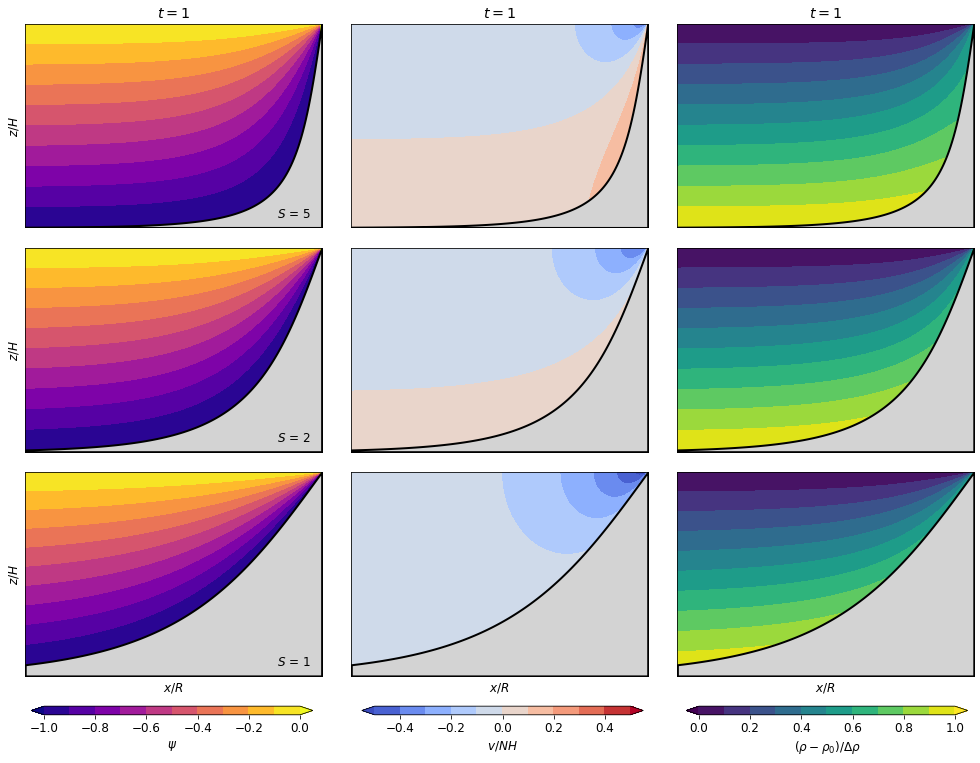

In [5]:
# Plot Choboter et al. 2011 solutions
plot_solutions()

***

## Upwelling diagnostics

### Depth of upwelling

We can readily obtain the depth of upwelling by solving for the initial (or offshore) depth $z$ of the densest isopycnal to reach the surface using the closed-form solution for $\rho$. First I set the density along the bathymetry equal to the initial (offshore) density (which is just equal to $-z$)

$$\rho(x_b, z_b, t) = \rho(x, z, 0) = -z(x_b, z_b, t)$$

Near the coast, $x_b = z_b/\tan\mu$. Substituting for $x_b$ we get the following expression for $z(z_b, t)$

$$z(z_b, t) = -\frac{1}{2\mu}\cos^{-1}\left\{\cos2\mu z_b - \frac{\sin^22\mu z_b\left(1 - e^{-2\alpha\mu t}\right)}{\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b}\right\}$$

In order to consider the depth of upwelling at the coast, we take the limit as $z_b \to 0$

$$z(t) = \lim_{z_b\to0}z(z_b, t) = -\frac{1}{2\mu}\cos^{-1}\left\{1 - \beta\left(1 - e^{-2\alpha\mu t}\right)\right\}$$

where (using L'H&ocirc;pital's Rule)

$$\beta = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(\sin^22\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b\right)} = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(2\cos2\mu z_b\sin2\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\sinh\frac{2\mu z_b}{\tan\mu} + \sin2\mu z_b\right)} = \lim_{z_b\to0}\frac{2\left(\cos^22\mu z_b - \sin^22\mu z_b\right)}{\frac{1}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu} + \cos2\mu z_b} = \frac{2}{\frac{1}{\tan^2\mu} + 1}$$

In dimensional terms, the depth of upwelling is predicted as

$$\boxed{\hspace{0.5cm}\frac{z_u}{H} = \frac{1}{2\mu}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\bigg(1 - e^{-2\alpha\mu t/T}\bigg)\right\}\hspace{0.5cm}}$$

At low Burger number this upwelling depth increases with Burger number, as shown in the figure below.

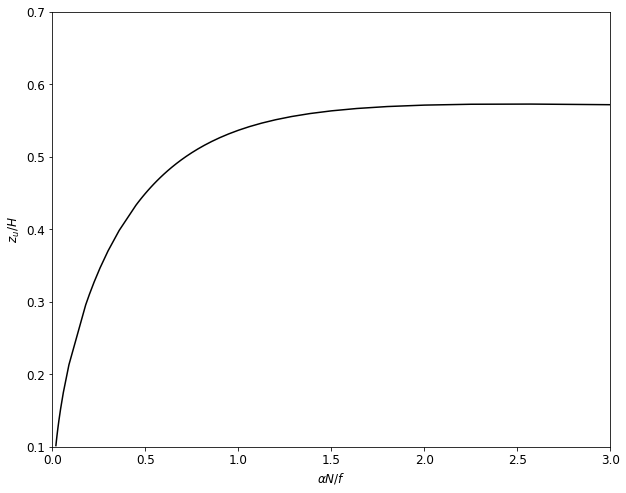

In [6]:
# Plot upwelling depth
plot_upwelling_depth()

***

### Displacement of the pycnocline front

**Theory**

Finding a Burger number dependent pycnocline front displacement from the Choboter et al. 2011 model is a bit more complicated than deriving a depth of upwelling. To conserve mass, the volume flux into the upper layer is defined as the offshore surface Ekman flux.

$$\phi = \frac{\tau}{\rho_0f}$$

The surface Ekman layer thickness is not resolved and assumed to be constant, and thus the surface offshore velocity is independent of Burger number.

$$v = \frac{\tau}{\rho_0fz_h}$$

However, the flux converges to a singular point in the upper right corner of the domain while we know that the isopycnals should lift through the initial pycnocline depth and spread offshore. Since these isopycnals are shallower near the coast at low Burger number due to the constraints of the topography, the volume displaced by isopycnal shoaling should be Burger number dependent.

Consider the figure below.

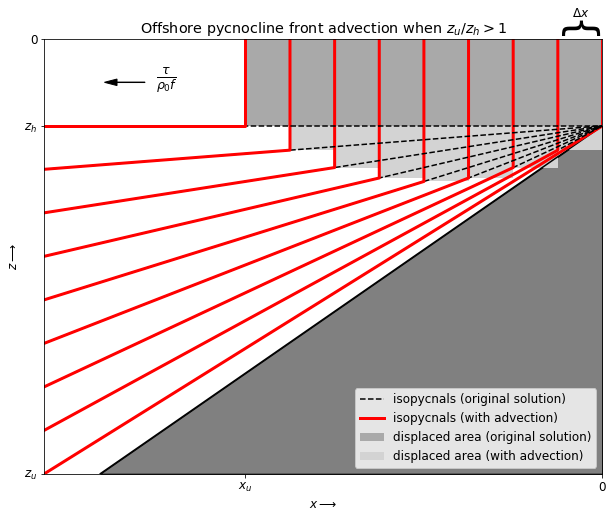

In [7]:
# Plot isopycnal diagram
isopycnal_diagram()

There is clearly an additional displacement volume not accounted for in the model as the isopycnals lift and advect offshore (approximated using rectangles). This volume grows with increasing Burger number, and by conservation of mass the offshore velocity and displacement decreases as we observe in the NEMO results.

***

**Deriving an expression for offshore pycnocline displacement**

   1. **Isopycnal depth**

   In order to approximate the displaced area shown in the figure above, we need the depth of each isopycnal at the approximate distance offshore where they surface. We can obtain a general expression for the depth of an isopycnal by solving the $\rho$ solution for depth $z$.

   $$\rho(x, z, t) = \frac{1}{2\mu}\cos^{-1}\left(\cos2\mu z - \frac{\sin^22\mu z\left(1 - e^{-2\mu\alpha t}\right)}{\cosh2\mu x - \cos2\mu z}\right)$$

   Thus far, the simplest way I've found to do this is to express the equation as a quadratic in terms of $\phi = \cos2\mu z$

   $$A\phi^2 - (B + C)\phi + (BC - A + 1) = 0$$

   \begin{align}
   \phi & = \cos2\mu z \\
   A & = e^{-2\mu\alpha t} \\
   B & = \cosh2\mu x \\
   C & = \cos2\mu\rho
   \end{align}

   and solve for $\phi$ using the quadratic formula

   $$\phi = \frac{B + C \pm \sqrt{(B + C)^2 - 4A(BC - A + 1)}}{2A} = \frac{B + C}{2A} \pm \sqrt{\left(\frac{B + C}{2A}\right)^2 - \frac{BC + 1}{A} + 1} = \beta \pm \sqrt{\beta^2 - \gamma + 1}$$

   where

   $$\beta = \frac{\cosh2\mu x + \cos2\mu\rho}{2e^{-2\mu\alpha t}}, \hspace{1cm} \gamma = \frac{\cosh2\mu x\cos2\mu\rho + 1}{e^{-2\mu\alpha t}}$$

   Thus

   $$\boxed{\hspace{0.5cm}z(\rho, x, t) = \frac{1}{2\mu}\cos^{-1}\left(\beta - \sqrt{\beta^2 - \gamma + 1}\right)\hspace{0.5cm}}$$

   where only the negative root gives defined solutions.
   
   
   2. **Maximum upwelled density**
   
   The non-dimensional isopycnal densities in question will range between 0 and the maximum upwelled density $\rho_u$. Since the offshore non-dimensional density $\rho$ is equal to the offshore non-dimensional depth $z$

   $$\boxed{\hspace{0.5cm}\rho_u(t) = \frac{z_u}{H} = \frac{1}{2\mu}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - e^{-2\alpha\mu t}\right)\right\}\hspace{0.5cm}}$$
   
   
   3. **Estimating the offshore displacement**
   
   I define the displaced area shown in the above figure as the sum of the rectangles given by the isopycnal depths and the offshore isopycnal front positions
   
   $$\text{Area} = \sum_{n=1}^{x_u/\Delta x}z(\rho_n, x_n, t)\Delta x$$
   
   where $x_n$ increases monotonically away from the coast, $\rho_n$ decreases monotonically upward from $\rho_u$, and $\Delta x$ is sufficiently small relative to the offshore pycnocline displacement $x_u$
   
   $$x_n = -n\Delta x, \hspace{1cm} \rho_n = \left(1 - \frac{n\Delta x}{x_u}\right)\rho_u, \hspace{1cm} \frac{\Delta x}{x_u} \ll 1$$
   
   Solving the area expression for the offshore pycnocline displacement $x_u$ is not trivial, so instead I iterate the calculation to minimize the residual $\hat{R}$ between the area and the cumulative offshore surface Ekman flux
   
   $$\boxed{\hspace{0.5cm}\hat{R}(x_u) = \sum_{n=1}^{x_u/\Delta x}z(\rho_n, x_n, t)\Delta x - \frac{\tau t}{\rho_0f}\hspace{0.5cm}}$$
   
To get an idea of the residual in $S$-$x_u$ space, consider the plot below.

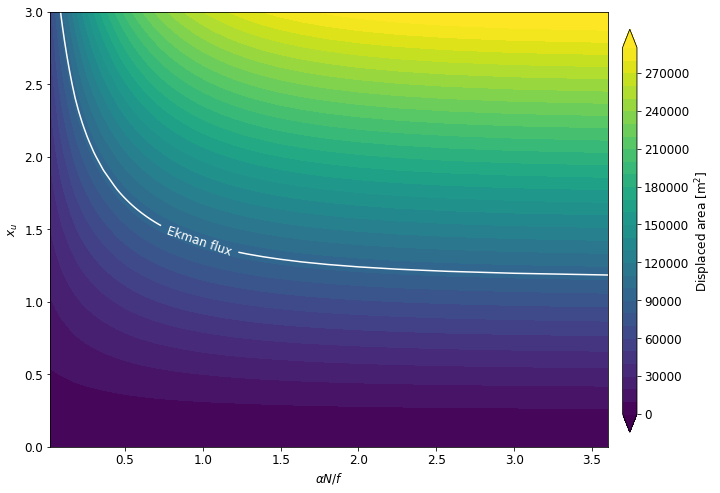

In [8]:
# Show displacement area plot
plot_area()

And solving the iteration described above gives us the contour from the above area plot as $x_u$ as a function of Burger number.

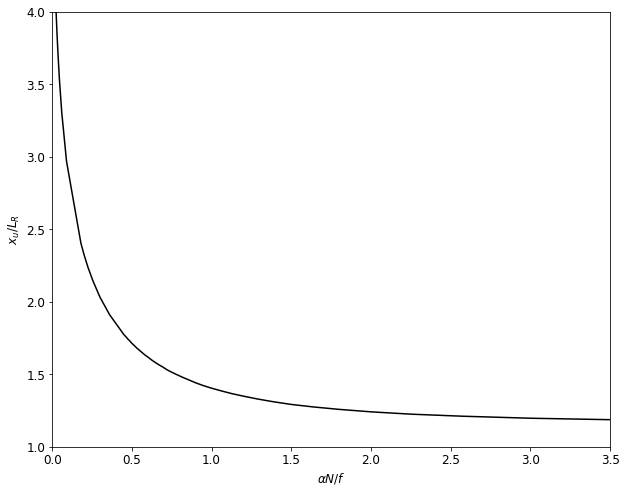

In [20]:
# Plot pycnocline displacement
plot_pycnocline_displacement()

***

## Idealized model comparisons

Load and process idealized, constant stratification runs

In [61]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}

# Build coastline index arrays
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)

# Process idealized 2-layer results
runs_idealized = ps.process_idealized_results(param, sections, mask, grids, keys=['z_h', 'rho_s', 'u_wind'])

# Load processed hindcast results
runs_hindcast = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/notebooks/SOG_upwelling_paperfigs/hindcast_processed.nc')

Plot constant stratification results against Choboter et al. 2011 model

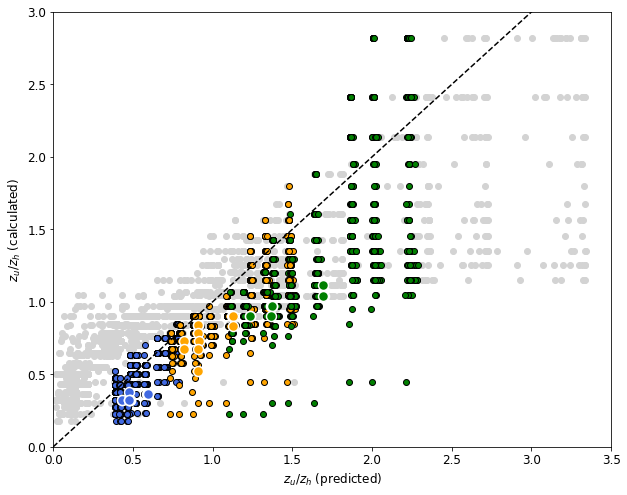

In [273]:
# -- Plot Choboter et al. 2011 upwelling diagnostics --
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 4], [0, 4], 'k--')
ax.set_xlim([0, 3.5])
ax.set_ylim([0, 3])
ax.set_xlabel('$z_u/z_h$ (predicted)')
ax.set_ylabel('$z_u/z_h$ (calculated)')

# Constants
alpha = 1
t = 86400

# Define tau j component
jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

# Loop through run parameters
for z_h in param['z_h']:
    for rho_s in param['rho_s']:
        
        # Define reduced gravity and internal Rossby radius
        N = np.sqrt(const['g'] / const['rho_0'] * (const['rho_0'] - rho_s) / z_h)
        g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
        S = sections['slope'] * N / const['f']
        
        # Loop through windspeed, windstress
        for U, tau, color in zip(param['u_wind'], param['tau'], ['royalblue', 'orange', 'g']):
            
            # Define upwelling predictor and plot
            T = const['rho_0'] * N * const['H']**2 / tau
            exp = 1 - np.exp(-2 * alpha * np.arctan(S) * t / T)
            Z = -np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S)) * const['H'] / z_h
            ftW = tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
            
            ax.plot(ftW, np.array(runs_idealized[z_h][rho_s][U]['z_u']) / z_h, 'o', color='lightgray', zorder=0)
            ax.plot(-Z, np.array(runs_idealized[z_h][rho_s][U]['z_u']) / z_h, 'ko', markerfacecolor=color, zorder=1)
            index = S < 6
            ax.plot(
                -Z[index], np.array(runs_idealized[z_h][rho_s][U]['z_u'])[index] / z_h,
                'wo', markerfacecolor=color, markersize=10, markeredgewidth=1.5,
            )

# Make legend
plt.show()

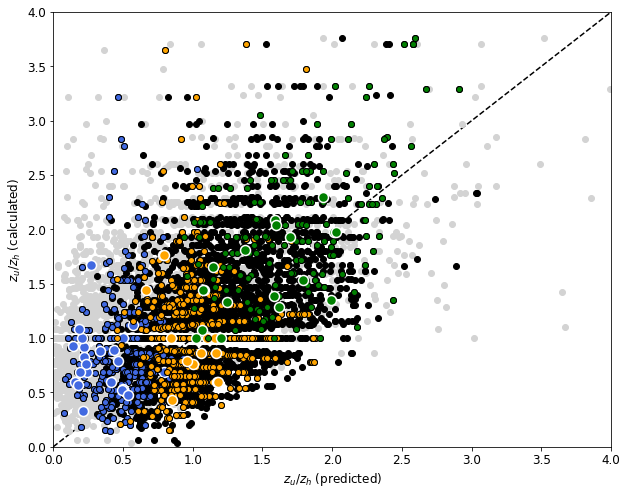

In [267]:
# -- Plot Choboter et al. 2011 upwelling diagnostics --
fig, ax = plt.subplots(figsize=(10, 8))
#cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
ax.plot([0, 4], [0, 4], 'k--')
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_xlabel('$z_u/z_h$ (predicted)')
ax.set_ylabel('$z_u/z_h$ (calculated)')

# Constants
alpha = 1
t = 86400
            
# Define upwelling predictor ft/W
tau = runs_hindcast.tau.values.flatten()/86400
z_h = runs_hindcast.z_h.values
g_prime = const['g'] * (const['rho_0'] - runs_hindcast.rho_s.values) / const['rho_0']
S = sections['slope'] * runs_hindcast.N_int / const['f'] / const['H']
T = const['rho_0'] * N * const['H']**2 / runs_hindcast.tau
exp = 1 - np.exp(-2 * alpha * np.arctan(S) / T)
Z = -np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S)) * const['H'] / z_h
ftW = runs_hindcast.tau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))

ax.plot(ftW.values.flatten(), (runs_hindcast.z_u / z_h).values.flatten(), 'o', color='lightgray')
ax.plot(-Z.values.flatten(), (runs_hindcast.z_u / z_h).values.flatten(), 'ko')


cutoff_tau = [(0, 0.01), (0.02, 0.03), (0.1, 0.5)]
index = (S.values.flatten() < 2)

for ctau, color in zip(cutoff_tau, ['royalblue', 'orange', 'green']):
    itau = (tau > ctau[0]) & (tau < ctau[1])
    ax.plot(
        -Z.values.flatten()[itau], (runs_hindcast.z_u / z_h).values.flatten()[itau],
        'ko', markerfacecolor=color,
    )
    ax.plot(
        -Z.values.flatten()[index & itau], (runs_hindcast.z_u / z_h).values.flatten()[index & itau],
        'wo', markerfacecolor=color, markersize=10, markeredgewidth=1.5, 
    )

#fig.colorbar(c, cax=cax, label='$\\tau$')